In [327]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib as plt
import requests
from urllib.parse import quote
import json
import pyproj
import os
os.chdir("D:/Projects/crime-prediction")

import common.census_tract as tract

pyproj.datadir.set_data_dir("D:/ProgramData/anaconda3/envs/crime-prediction/Library/share/proj")

In [328]:
poverty_levels_path = 'data/poverty_status.csv'
census_tracts_path='data/preprocessed/census_tracts_data.geojson'

In [329]:
def parse_census_tracts_data():
    gdf = gpd.read_file(census_tracts_path)
    return gdf

In [330]:
tracts_gdf = parse_census_tracts_data()

In [331]:
def parse_poverty_levels():
    # Read poverty level data from CSV file, selecting only needed columns
    df = pd.read_csv(
         poverty_levels_path,
         usecols= [
             'Total population for whom poverty status is determined', 
             'Below poverty level',
             'Tract Name'
         ],
         dtype={
             'Tract Name': 'category'  # Set Tract Name as categorical data type for efficiency
         }
        )
    
    # Rename columns to more concise names
    df = df.rename(columns={'Total population for whom poverty status is determined': 'Tract Population', 'Below poverty level': 'Tract Population Below Poverty'})
    
    # Format tract names using helper function
    df["Tract Name"] = df.apply(lambda row: tract.formatTractName(row["Tract Name"]) , axis=1)
    
    # Create tract group names using helper function
    df["Tract Group Name"] = df.apply(lambda row: tract.formatTractGroupName(row["Tract Name"]) , axis=1)

    # Aggregate data at the tract level (mean values)
    df_1 = df.groupby("Tract Name")[["Tract Population", 'Tract Population Below Poverty']].agg('mean').reset_index()
    
    # Aggregate data at the tract group level (mean values)
    df_2 = df.groupby("Tract Group Name")[["Tract Population", 'Tract Population Below Poverty']].agg('mean') \
                        .reset_index() \
                        .rename(columns={'Tract Group Name': 'Tract Name'})
    
    # Combine both aggregations and calculate mean values if there are duplicates
    df = pd.concat([df_1, df_2]).groupby("Tract Name")[["Tract Population", 'Tract Population Below Poverty']].agg('mean').reset_index()
    
    # Filter to only include tracts that exist in the tracts_gdf dataset
    df = df[df['Tract Name'].isin(set(tracts_gdf["Tract Name"]))]
    
    # Merge with geographic data from tracts_gdf
    df = pd.merge(df, tracts_gdf, on='Tract Name', how='inner')
    
    # Convert to GeoDataFrame with appropriate coordinate reference system
    df = gpd.GeoDataFrame(df, geometry=df["geometry"], crs="EPSG:4326")
    
    return df

In [332]:
poverty_gdf = parse_poverty_levels()

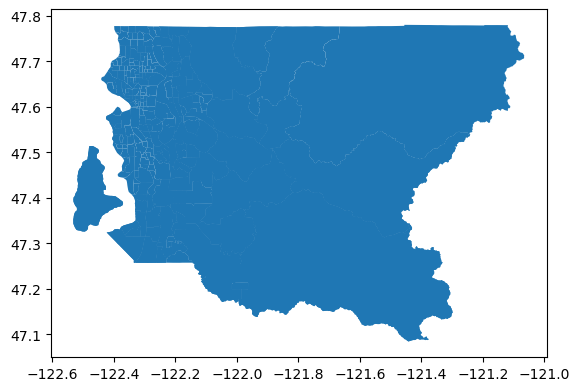

In [333]:
poverty_gdf.plot()
poverty_gdf.to_file('data/preprocessed/poverty_data.geojson', driver="GeoJSON")